In [3]:
from utils import *

In [4]:
json_path = r'data/catchments_long.json'
catchment_dict_list = long_json_to_list(json_path)

In [5]:
demo_catchment = catchment_dict_list[0]

grid_by_num_splits = corners_to_grid_by_num_splits(demo_catchment, 20)

In [6]:
api_response = elevation_api_caller(grid_by_num_splits)

In [7]:
elevation_grid_by_num_splits = parse_api_resonse_to_dataframe(api_response)

In [8]:
pivoted_elevation_grid_by_num_splits = elevation_grid_by_num_splits.pivot(index='latitude', columns='longitude', values='elevation')

In [9]:
transposed_pivoted_elevation_grid_by_num_splits = pivoted_elevation_grid_by_num_splits.transpose()

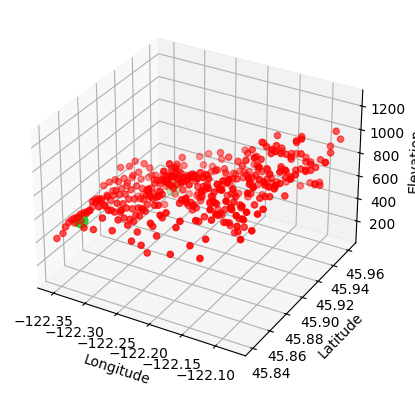

In [53]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy.ndimage as ndi

elevation_data = elevation_grid_by_num_splits
elevation_values = elevation_data['elevation']  # Assuming elevation values are stored in this column

# Create a local minima mask
local_minima_mask = elevation_values == ndi.minimum_filter(elevation_values, size=200)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with elevation as height
ax.scatter(elevation_data['longitude'], elevation_data['latitude'], elevation_data['elevation'], c='r', marker='o')

minima_x = elevation_data['longitude'][local_minima_mask]
minima_y = elevation_data['latitude'][local_minima_mask]
minima_z = elevation_data['elevation'][local_minima_mask]


ax.scatter(minima_x, minima_y, minima_z, c='limegreen', marker='o', s=100)  # Adjust 's' to control marker size

# Set labels
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation')

# Show the plot
plt.show()


In [54]:

import plotly.express as px

fig = px.scatter_3d(elevation_grid_by_num_splits, x='longitude', y='latitude', z='elevation', title='Elevation 3D Scatter Plot')

# Show the plot
fig.show()


In [55]:
#this one works!
import plotly.graph_objects as go
import numpy as np
z = np.array(elevation_grid_by_num_splits['elevation'])
x = np.array(elevation_grid_by_num_splits['latitude'])
y = np.array(elevation_grid_by_num_splits['longitude'])


#fig = go.Figure(data=[go.Surface(z=elevation_grid_by_num_splits.values[2], x=elevation_grid_by_num_splits.values[0], y=elevation_grid_by_num_splits.values[1])])

fig = go.Figure(data=[go.Surface(z=pivoted_elevation_grid_by_num_splits.values, x=pivoted_elevation_grid_by_num_splits.index, y=pivoted_elevation_grid_by_num_splits.columns)])


fig.update_layout(
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.2),
        aspectmode='manual'
    )
)

fig.show()

In [61]:
#for plotting local minima
import plotly.graph_objects as go
import numpy as np
import scipy.ndimage as ndi

z = np.array(elevation_grid_by_num_splits['elevation'])
x = np.array(elevation_grid_by_num_splits['latitude'])
y = np.array(elevation_grid_by_num_splits['longitude'])

# Create a local minima mask
local_minima_mask = elevation_values == ndi.minimum_filter(z, size=50)

# Extracting the minima coordinates
minima_x = x[local_minima_mask]
minima_y = y[local_minima_mask]
minima_z = z[local_minima_mask]

# Plot our elevation data, 
fig = go.Figure(data=[go.Surface(z=pivoted_elevation_grid_by_num_splits.transpose().values, x=pivoted_elevation_grid_by_num_splits.index, y=pivoted_elevation_grid_by_num_splits.columns)])
# fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5, color='limegreen', symbol='circle'), name='Scatterplot surface'))  # plots all points in scatterplot form

# Plot the local minima alongside the elevation data (as determined by the ndi filter)
fig.add_trace(go.Scatter3d(x=minima_x, y=minima_y, z=minima_z, mode='markers', marker=dict(size=5, color='limegreen', symbol='circle'), name='Local Minima'))

fig.update_layout(
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.2),
        aspectmode='manual'
    )
)

fig.show()

In [12]:
# test_data = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/api_docs/mt_bruno_elevation.csv')

In [62]:

import numpy as np
from scipy.optimize import minimize
import itertools

# Assuming df is your DataFrame
# Convert DataFrame to NumPy array
grid = pivoted_elevation_grid_by_num_splits.to_numpy()

# Objective function
def objective_function(coordinates):
    x, y = coordinates
    z = grid[y][x]  # z value at the given coordinates
    return z

# Example usage of the optimization algorithm (you may need to customize this)
def find_minima_for_set(initial_guess, bounds):
    result = minimize(objective_function, initial_guess, bounds=bounds)
    return result.fun, result.x

# Example: Iterate over sets of points
minima_sets = {}

x_indices = range(grid.shape[1])
y_indices = range(grid.shape[0])

for x, y in itertools.product(x_indices, y_indices):
    initial_guess = np.array(list(x) + list(y))
    bounds = [(0, grid.shape[1]-1), (0, grid.shape[0]-1)]

    min_value, min_points = find_minima_for_set(initial_guess, bounds)

    # Use min_value and min_points as needed
    minima_sets.setdefault(tuple(min_points), []).append(tuple(min_points))

# minima_sets now contains sets of points that lead to the same minima

TypeError: 'int' object is not iterable

In [ ]:
'''
min_lat_deg = elevation_grid_by_num_splits['latitude'].min()
min_lon_deg = elevation_grid_by_num_splits['longitude'].min()

m_elevation_grid_by_num_splits = pd.DataFrame()
m_elevation_grid_by_num_splits['elevation'] = elevation_grid_by_num_splits['elevation']
m_elevation_grid_by_num_splits['latitude_diff'] = elevation_grid_by_num_splits['latitude'] - min_lat_deg
m_elevation_grid_by_num_splits['longitude_diff'] = elevation_grid_by_num_splits['longitude'] - min_lon_deg
#round all values in longitude_diff to 2 sig figs
m_elevation_grid_by_num_splits['longitude_diff'] = m_elevation_grid_by_num_splits['longitude_diff'].round(decimals=2)

m_elevation_grid_by_num_splits['latitude_m'] = m_elevation_grid_by_num_splits['latitude_diff'] * 110574
m_elevation_grid_by_num_splits['longitude_m'] = m_elevation_grid_by_num_splits['longitude_diff'] * 111320 * np.cos(m_elevation_grid_by_num_splits['latitude_diff'])
#round all values in longitude_m and latitude_m to nearest integer
m_elevation_grid_by_num_splits['latitude_m'] = m_elevation_grid_by_num_splits['latitude_m'].round(decimals=-2)
m_elevation_grid_by_num_splits['longitude_m'] = m_elevation_grid_by_num_splits['longitude_m'].round(decimals=-2)

#m_elevation_grid_by_num_splits = m_elevation_grid_by_num_splits[['elevation', 'latitude_m', 'longitude_m']]

pivoted_m_elevation_grid_by_num_splits = m_elevation_grid_by_num_splits.pivot(index='latitude_m', columns='longitude_m', values='elevation')
'''
#tried converting lat/lon to meters, but it didn't work (spheres are not flat, duh)

In [63]:
test_point = find_minima_for_point(lat_idx= 10, lon_idx= 10, radius= 1, df=pivoted_elevation_grid_by_num_splits)
print(grid[test_point])

325.0


In [64]:
size = 20
results = []
for i in range(size):
    for j in range(size):
        (dest_lat, dest_lon) = find_minima_for_point(lat_idx= i, lon_idx= j, radius= 1, df=pivoted_elevation_grid_by_num_splits)
        result = {'start_lat': i, 'start_lon': j, 'dest_lat': dest_lat, 'dest_lon': dest_lon}
        results.append(result)


In [65]:
minimas = []
for item in results:
    if item['start_lat'] == item['dest_lat'] and item['start_lon'] == item['dest_lon']:
        minimas.append((item['start_lat'], item['start_lon']))

In [66]:
minima_point_groups = []
for minima in minimas:
    minima_group = []
    for point in results:
        if point['dest_lat'] == minima[0] and point['dest_lon'] == minima[1]:
            minima_group.append((point['start_lat'], point['start_lon']))
    minima_point_groups.append(minima_group)

In [67]:
#for plotting local minima
import plotly.graph_objects as go
import numpy as np
import scipy.ndimage as ndi

test_group = minima_point_groups[23]
print(test_group)
np_test_group = np.array(test_group)
np_test_group_lats = [pivoted_elevation_grid_by_num_splits.index[item] for item in np_test_group[:,0]]
np_test_group_lons = [pivoted_elevation_grid_by_num_splits.columns[item] for item in np_test_group[:,1]]


# Plot our elevation data, 
fig = go.Figure(data=[go.Surface(z=pivoted_elevation_grid_by_num_splits.transpose().values, x=pivoted_elevation_grid_by_num_splits.index, y=pivoted_elevation_grid_by_num_splits.columns)])
# fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=5, color='limegreen', symbol='circle'), name='Scatterplot surface'))  # plots all points in scatterplot form

fig.add_trace(go.Scatter3d(x=np_test_group_lats, y=np_test_group_lons, z=np.full(38, 1000, dtype=int), mode='markers', marker=dict(size=5, color='limegreen', symbol='circle'), name='catchment points'))

fig.add_trace(go.Scatter3d(x=[pivoted_elevation_grid_by_num_splits.index[minimas[23][0]]], y=[pivoted_elevation_grid_by_num_splits.columns[minimas[23][1]]], z=np.full(1, 1000, dtype=int), mode='markers', marker=dict(size=5, color='red', symbol='circle'), name='Local Minima'))


fig.update_layout(
    scene=dict(
        aspectratio=dict(x=1, y=1, z=0.2),
        aspectmode='manual'
    )
)

fig.show()

[(6, 8), (7, 3), (7, 4), (7, 5), (7, 7), (8, 3), (8, 4), (8, 5), (8, 6), (8, 7), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (12, 2), (12, 3), (12, 4), (12, 5), (13, 2), (13, 3), (13, 4), (13, 5), (14, 2), (14, 3), (14, 4), (15, 3), (15, 4)]


In [44]:
buffer=np.array(np_test_group[:,0])